In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt

np.random.seed(42)
torch.manual_seed(42)

In [2]:
device = torch.device("mps:0" if torch.backends.mps.is_available() else "cpu")
print(f"Using {device} device")

Using mps:0 device


In [3]:
print (f"PyTorch version:{torch.__version__}") # 1.12.1 이상
print(f"MPS 장치를 지원하도록 build 되었는지: {torch.backends.mps.is_built()}") # True 여야 합니다.
print(f"MPS 장치가 사용 가능한지: {torch.backends.mps.is_available()}") # True 여야 합니다.
!python -c 'import platform;print(platform.platform())'

PyTorch version:2.1.2
MPS 장치를 지원하도록 build 되었는지: True
MPS 장치가 사용 가능한지: True


macOS-14.2-arm64-arm-64bit


In [4]:
# Custom Dataset 정의
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, label=0):
        self.img_dir = img_dir
        self.transform = transform
        self.label = label
        self.img_paths = [os.path.join(img_dir, img_file) for img_file in os.listdir(img_dir) if img_file.lower().endswith(("png", "jpg", "jpeg"))]

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, self.label

# 이미지 경로
root_dir = "/Users/eric/Documents/Research/CDAL/2023_Winter/summer2winter_yosemite"

# 이미지 변환 설정
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 데이터셋 생성
train_dataset_A = CustomImageDataset(os.path.join(root_dir, "trainA"), transform=transform, label=0)
train_dataset_B = CustomImageDataset(os.path.join(root_dir, "trainB"), transform=transform, label=1)
test_dataset_A = CustomImageDataset(os.path.join(root_dir, "testA"), transform=transform, label=0)
test_dataset_B = CustomImageDataset(os.path.join(root_dir, "testB"), transform=transform, label=1)

# 데이터셋 합치기
train_dataset = ConcatDataset([train_dataset_A, train_dataset_B])
test_dataset = ConcatDataset([test_dataset_A, test_dataset_B])

# 검증 데이터셋 분할
val_split = 0.2
train_size = int((1 - val_split) * len(train_dataset))
val_size = len(train_dataset) - train_size

# 랜덤 시드를 사용하여 데이터셋 분할
generator = torch.Generator().manual_seed(42)  # 동일한 분할을 위한 시드 설정, 안하면 Accuracy & Loss가 매 epoch마다 동일하게 나옴
train_dataset_split, val_dataset_split = random_split(
    train_dataset, [train_size, val_size], generator=generator)

# DataLoader 생성
train_loader = DataLoader(train_dataset_split, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset_split, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [5]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, 2)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 256 * 32 * 32)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))

        return x

In [6]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [7]:
# Model(GPU로 이동), Loss Function, Optimizer 설정
model = CNNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
early_stopping = EarlyStopping(patience=5, min_delta=0.001)

In [8]:
# Mixup 처리 함수 정의
def mixup_data(x, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size(0)
    index = torch.randperm(batch_size)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [9]:
# 손실 및 정확도 추적을 위한 리스트
train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []

# 훈련 및 검증
epochs = 20
final_epoch = 0

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += batch_y.size(0)
        train_correct += (predicted == batch_y).sum().item()
        loss.backward()
        optimizer.step()

    train_loss /= train_total
    train_accuracy = 100 * train_correct / train_total

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for batch_X_val, batch_y_val in val_loader:
            batch_X_val, batch_y_val = batch_X_val.to(device), batch_y_val.to(device)
            outputs_val = model(batch_X_val)
            loss_val = criterion(outputs_val, batch_y_val)
            val_loss += loss_val.item()
            _, predicted_val = torch.max(outputs_val.data, 1)
            val_total += batch_y_val.size(0)
            val_correct += (predicted_val == batch_y_val).sum().item()

    val_loss /= val_total
    val_accuracy = 100 * val_correct / val_total

    # Early Stopping 체크
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(
        f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%"
    )
    
    final_epoch = epoch + 1


Epoch 1/20, Train Loss: 0.0354, Train Accuracy: 55.59%, Val Loss: 0.0221, Val Accuracy: 58.31%
Epoch 2/20, Train Loss: 0.0217, Train Accuracy: 55.53%, Val Loss: 0.0221, Val Accuracy: 58.31%
Epoch 3/20, Train Loss: 0.0217, Train Accuracy: 55.59%, Val Loss: 0.0221, Val Accuracy: 58.31%


KeyboardInterrupt: 

In [ ]:
def test(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# 테스트 세트에서의 성능
test_accuracy = test(model, test_loader)
print(f"Test Accuracy: {test_accuracy:.2f}%")


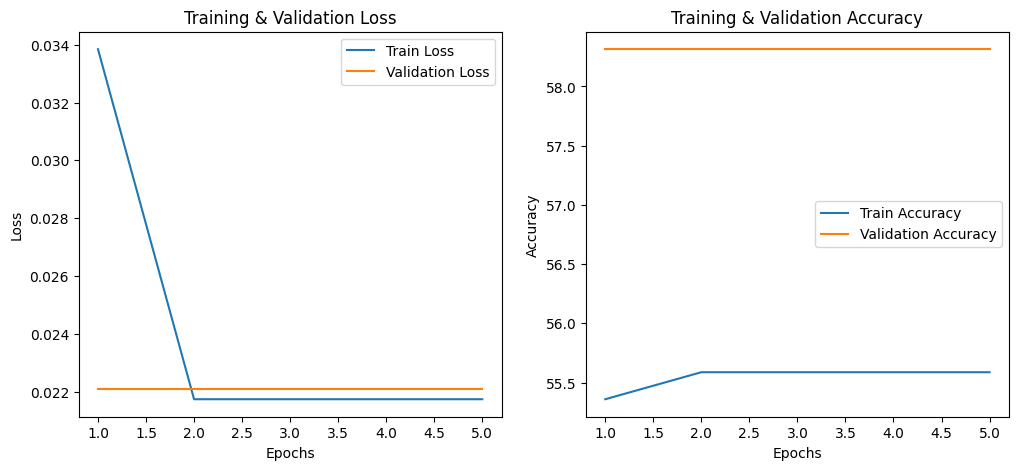

In [ ]:
import matplotlib.pyplot as plt

# Early Stopping이 일어난 경우, 실제로 완료된 에포크 수: final_epoch

# 손실 및 정확도 그래프 그리기
plt.figure(figsize=(12, 5))

# 손실 그래프
plt.subplot(1, 2, 1)
plt.plot(range(1, final_epoch + 1), train_losses[:final_epoch], label="Train Loss")
plt.plot(range(1, final_epoch + 1), val_losses[:final_epoch], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()

# 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(range(1, final_epoch + 1), train_accuracies[:final_epoch], label="Train Accuracy")
plt.plot(range(1, final_epoch + 1), val_accuracies[:final_epoch], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()

plt.show()


In [ ]:
def check_dataset_balance(dataset):
    labels = [label for _, label in dataset]
    label_counts = {label: labels.count(label) for label in set(labels)}
    return label_counts

# train, validation, test 데이터셋의 클래스 분포를 확인합니다.
train_dataset_balance = check_dataset_balance(train_dataset)
val_dataset_balance = check_dataset_balance(val_dataset_split)
test_dataset_balance = check_dataset_balance(test_dataset)

print("Train Dataset Balance:", train_dataset_balance)
print("Validation Dataset Balance:", val_dataset_balance)
print("Test Dataset Balance:", test_dataset_balance)


Train Dataset Balance: {0: 1231, 1: 962}
Validation Dataset Balance: {0: 256, 1: 183}
Test Dataset Balance: {0: 309, 1: 238}


In [ ]:
# 데이터 로더가 올바른 데이터셋을 참조하는지 확인
def check_dataloader(dataloader):
    for images, labels in dataloader:
        # 첫 번째 배치의 첫 번째 이미지와 레이블을 출력
        print("First image shape:", images[0].shape)
        print("First image label:", labels[0])
        break

print("Train Loader:")
check_dataloader(train_loader)
print("\nValidation Loader:")
check_dataloader(val_loader)
print("\nTest Loader:")
check_dataloader(test_loader)


Train Loader:
First image shape: torch.Size([3, 256, 256])
First image label: tensor(0)

Validation Loader:
First image shape: torch.Size([3, 256, 256])
First image label: tensor(0)

Test Loader:
First image shape: torch.Size([3, 256, 256])
First image label: tensor(0)
